In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import copy
import random
import pandas as pd


In [2]:
torch.cuda.empty_cache()  # 釋放占用的GPU記憶體
# 讓cuDNN尋找最快速的卷積演算法 (如果沒裝CUDA應該就不會裝cuDNN，所以應該就刪掉它)
torch.backends.cudnn.benchmark = True


### Creating image datasets an data loaders for train and test using the experiments folder split

In [3]:
folder = "./experiments"
data_path = os.path.join(folder, "data")  # data
experiments_path = os.path.join(folder, "dest_folder")  # dest_folder

mask_tags = ["with_black_mask", "with_blue_mask", "with_white_mask"]

dataset_without_mask, dataset_with_mask = [], []

# rebuilt folder experiments with ../Data Generator/data
if os.path.isdir(folder):
    shutil.rmtree(folder)
os.mkdir(folder)
os.mkdir(data_path)
os.mkdir(experiments_path)
os.mkdir(os.path.join(data_path, "with_mask"))
source_path = "../Data Generator/data/"

# built ./experiments/data/without_mask
try:
    shutil.copytree(os.path.join(source_path, "without_mask"),
                    os.path.join(data_path, "without_mask"))
    dataset_without_mask = os.listdir(os.path.join(data_path, "without_mask"))
except Exception as e:
    print("Error(without_mask): ", e)
# built ./experiments/data/with_mask
for f in os.listdir(os.path.join(source_path, "without_mask")):
    tag = mask_tags[random.randint(0, 2)]
    img = os.path.join(source_path, tag, f)
    if os.path.isfile(img):
        try:
            shutil.copy(img, os.path.join(data_path, "with_mask"))
            dataset_with_mask.append(f)
        except Exception as e:
            print("Error(with_mask): ", e)
# split train, test dataset
train_data1, test_data1 = train_test_split(
    dataset_without_mask, test_size=0.1, shuffle=True, random_state=None)
train_data2, test_data2 = train_test_split(
    dataset_with_mask, test_size=0.1, shuffle=True, random_state=None)
# create train.csv
train_data = train_data1+train_data2
train_class_list = ["with_mask"] * \
    len(train_data1)+["without_mask"]*len(train_data2)
train_df = pd.DataFrame(list(zip(train_data, train_class_list)), columns=[
                        'filename', 'class'])
train_df.to_csv(os.path.join(experiments_path, "train.csv"), index=False)
# create test.csv
test_data = test_data1+test_data2
test_class_list = ["with_mask"] * \
    len(test_data1)+["without_mask"]*len(test_data2)
test_df = pd.DataFrame(list(zip(test_data, test_class_list)), columns=[
                       'filename', 'class'])
test_df.to_csv(os.path.join(experiments_path, 'test.csv'), index=False)


In [4]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
    # train.csv或test.csv的路徑
    file_path = os.path.join(experiments_path, file_name)
    # CSV = Comma-Separated Values
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for row in train_df.iterrows():
        # 圖檔在with_mask或without_mask資料夾中的路徑
        files_path.append(os.path.join(
            data_path, row[1]['class'], row[1]['filename']))
        fonts_class.append(row[1]['class'])  # 圖檔類型(with_mask, without_mask)

    return files_path, fonts_class  # 回傳圖檔路徑、類型


In [5]:
# 用來將.jpg圖檔從data資料夾複製到train或test資料夾中的with_mask和without_mask子資料夾
def copy_images_to_path(file_path, file_class, destination_dir):
    font_folder = os.path.join(destination_dir, file_class)  # train或test資料夾路徑
    # 若with_mask、without_mask資料夾不存在，新增資料夾
    if os.path.exists(font_folder) == False:
        os.makedirs(font_folder)

    print("File being copied from {}:{}".format(file_path, font_folder))
    shutil.copy(file_path, font_folder)  # 從data資料夾複製圖檔(包含存取權)到train或test資料夾


In [6]:
# 由train.csv取得train資料夾的.jpg圖檔在data資料夾中的路徑和類型(with_mask, without_mask)
X_train, y_train = get_train_files_path(
    experiments_path, data_path, phase='train')
# 由test.csv取得test資料夾的.jpg圖檔在data資料夾中的路徑和類型(with_mask, without_mask)
X_test, y_test = get_train_files_path(
    experiments_path, data_path, phase='test')


In [7]:
train_dir = os.path.join(experiments_path, 'train')  # trsin資料夾路徑
test_dir = os.path.join(experiments_path, 'test')  # test資料夾路徑
# 若train資料夾不存在，新增資料夾
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
# 若test資料夾不存在，新增資料夾
if not os.path.exists(test_dir):
    os.makedirs(test_dir)


In [8]:
# 將.jpg圖檔從data資料夾複製到train資料夾
for file_path, font_class in zip(X_train, y_train):
    try:
        copy_images_to_path(file_path, font_class, train_dir)
    except Exception as e:
        print("Error(copy to train): ", e)


File being copied from ./experiments\data\with_mask\45.jpg:./experiments\dest_folder\train\with_mask
File being copied from ./experiments\data\with_mask\203.jpg:./experiments\dest_folder\train\with_mask
File being copied from ./experiments\data\with_mask\augmented_image_224.jpg:./experiments\dest_folder\train\with_mask
Error(copy to train):  [Errno 2] No such file or directory: './experiments\\data\\with_mask\\augmented_image_224.jpg'
File being copied from ./experiments\data\with_mask\299.jpg:./experiments\dest_folder\train\with_mask
File being copied from ./experiments\data\with_mask\augmented_image_314.jpg:./experiments\dest_folder\train\with_mask
Error(copy to train):  [Errno 2] No such file or directory: './experiments\\data\\with_mask\\augmented_image_314.jpg'
File being copied from ./experiments\data\with_mask\400.jpg:./experiments\dest_folder\train\with_mask
File being copied from ./experiments\data\with_mask\augmented_image_145.jpg:./experiments\dest_folder\train\with_mask
Err

In [9]:
# 將.jpg圖檔從data資料夾複製到test資料夾
for file_path, font_class in zip(X_test, y_test):
    try:
        copy_images_to_path(file_path, font_class, test_dir)
    except Exception as e:
        print("Error(copy to test): ", e)


File being copied from ./experiments\data\with_mask\augmented_image_193.jpg:./experiments\dest_folder\test\with_mask
Error(copy to test):  [Errno 2] No such file or directory: './experiments\\data\\with_mask\\augmented_image_193.jpg'
File being copied from ./experiments\data\with_mask\108.jpg:./experiments\dest_folder\test\with_mask
File being copied from ./experiments\data\with_mask\augmented_image_92.jpg:./experiments\dest_folder\test\with_mask
Error(copy to test):  [Errno 2] No such file or directory: './experiments\\data\\with_mask\\augmented_image_92.jpg'
File being copied from ./experiments\data\with_mask\275.jpg:./experiments\dest_folder\test\with_mask
File being copied from ./experiments\data\with_mask\augmented_image_54.jpg:./experiments\dest_folder\test\with_mask
Error(copy to test):  [Errno 2] No such file or directory: './experiments\\data\\with_mask\\augmented_image_54.jpg'
File being copied from ./experiments\data\with_mask\26.jpg:./experiments\dest_folder\test\with_mask


In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # 將圖片隨機裁剪成(224,224)的大小
        transforms.ToTensor(),  # 轉換成Tensor (torch.Tensor是同種資料類型的多維矩陣)
        # 標準化：torchvision.transforms.Normalize(mean, std) (output[i] = (input[i]-mean[i])/std[i])
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),  # 將圖片縮放成(256,256)
        transforms.CenterCrop(224),  # 從中央將圖片裁剪成(224,224)
        transforms.ToTensor(),  # 轉換成Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [
                             0.229, 0.224, 0.225])  # 標準化
    ])
}


In [11]:
# 建立數據集字典image_datasets，包含數據集train和test，內容分別是train和test資料夾中經過轉換的圖檔
image_datasets = {x: datasets.ImageFolder(os.path.join(
    experiments_path, x), data_transforms[x]) for x in ['train', 'test']}


In [12]:
# 顯示數據集train的內容
image_datasets['train']


Dataset ImageFolder
    Number of datapoints: 662
    Root location: ./experiments\dest_folder\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [13]:
# 顯示數據集test的內容
image_datasets['test']


Dataset ImageFolder
    Number of datapoints: 74
    Root location: ./experiments\dest_folder\test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [14]:
# 定義dataloader字典
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              # 一次讀取的資料數(訓練時每次平行處理1 batch的資料) (若GPU記憶體無法負荷則改小)
                                              batch_size=8,
                                              shuffle=True,  # reshuffle the data at every epoch
                                              num_workers=4)  # 載入檔案所用的子進程(subprocess)數
               for x in ['train', 'test']}


In [15]:
dataloaders


{'train': <torch.utils.data.dataloader.DataLoader at 0x2c695dc6f10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2c695dc6a00>}

In [16]:
class_names = image_datasets['train'].classes  # with_mask、without_mask


In [17]:
class_names


['with_mask', 'without_mask']

In [18]:
# 指定資料記憶體位置(應該可以理解成處理的裝置)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [19]:
device


device(type='cuda')

In [20]:
# 數據集大小(圖片數)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}


In [21]:
dataset_sizes['train']


662

In [22]:
dataset_sizes['test']


74

### Visualizing images (not the must)

In [23]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = (inp-mean)/std
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)


In [24]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)


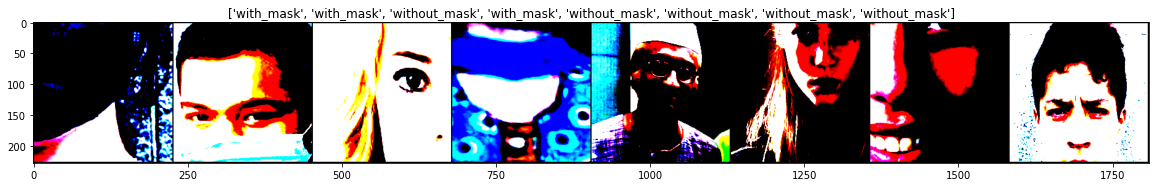

In [25]:
imshow(out, title=[class_names[x] for x in classes])


### Training the model

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=1):
    since = time.time()  # 訓練開始時間
    best_acc = 0.0  # 紀錄最佳精確度
    best_model = copy.deepcopy(model.state_dict())  # 紀錄最佳模型

    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        # print "Epoch 0/19", for example
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # 設為訓練模式
            else:
                model.eval()  # 設為評估模式

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                # 將inputs(影像)、labels(標籤，with_mask、without_mask)轉移到device
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()  # 梯度歸零

                # 若phase == 'train'，啟動梯度運算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # 　取得模型輸出結果
                    # 回傳outputs(Tensor)中(每行元素中的最大值,在該行中的位置(列索引))，資料類型：tensor
                    _, preds = torch.max(outputs, 1)
                    # 用損失函數計算loss，loss是一個tensor
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()  # 計算梯度
                        optimizer.step()  # 讓optimizer可以做事(利用損失函數優化模型)
                        scheduler.step()  # 讓scheduler可以做事(依照設定調整學習率)

                # lose.item()將loss從tensor轉成float32，loss.item()*batchsize = loss in abatch
                running_loss += loss.item() * inputs.size(0)
                # 計算模型結果與實際的相似度(？)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / \
                dataset_sizes[phase]  # 此epoch中的損失(與真實數據的落差)
            epoch_acc = running_corrects.double(
            ) / dataset_sizes[phase]  # 此epoch中的精確度

            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 若此次訓練模型較好，則取代舊模型
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())  # 紀錄最佳模型

            print()

    time_elapsed = time.time() - since  # 訓練總時間
    print('Training complete in {:0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model)  # 加載模型
    return model


In [27]:
# 使用已訓練的模型：resnet101
model_ft = models.resnet101(pretrained=True)

# 修改resnet101模型
num_frts = model_ft.fc.in_features  # 提取fc層的固定參數
# 將維度從num_frts修改為len(class_names)=2，也就是將原本resnet101模型的fc層1000種類別改成我們要的兩種類別：with_maask、without_mask
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)  # 將模型轉移到device('cpu'或'cuda')上
criterion = nn.CrossEntropyLoss()  # 使用損失函數CrossEntropyLoss()，loss可代表模型與實際狀況的誤差

# 使用SGD優化算法，lr(learing rate) = 0.01，動量 = 0.9
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.02, momentum=1.0)
# V = beta*V-lr*(dCriterion/dWeight)，W = W + V
# 使用學習率調整函數StepLR()，每step_size個epoch會將學習率調整為gamma倍
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [28]:
with torch.no_grad():
    model_ft = train_model(model_ft, criterion, optimizer_ft,
                           exp_lr_scheduler, num_epochs=3)  # 訓練模型


Epoch 0/2
----------
train Loss: 0.7543 Acc:0.8701

test Loss: 0.0031 Acc:1.0000

Epoch 1/2
----------
train Loss: 0.6191 Acc:0.8822

test Loss: 0.0016 Acc:1.0000

Epoch 2/2
----------
train Loss: 0.6603 Acc:0.8912

test Loss: 0.0002 Acc:1.0000

Training complete in 4.000000m 53s
Best val acc: 1.000000


In [29]:
torch.save(model_ft, "../mask_recognition_model.pth")  # 儲存模型為.pth檔
